# PPCA

$\mathcal{N}(z|0, \mu, \sigma^2)$

In [252]:
# from plot import *
from sampling import *

import numpy as np
import scipy.linalg as sl
from pathlib import Path


def import_data() -> np.array:
    fname = "data.txt"
    f = open(fname,'r')
    data = []
    for line in f:
        s = line.split()
        data.append([float(s[0]),float(s[1])])
    f.close()

    return np.array(data)


class ppca:

    def __init__(self, X=None, num_components=1, verbose=False):

        self.q = num_components
        self.d = X.shape[1]
        self.mu = None
        self.sigma2 = None
        self.weights = None
        self.verbose = verbose

        if X is not None:
            self.fit(X)


    def fit(self, X):

        # calculate maximum likelihood means
        self.mu = np.mean(X, axis=0)
        # print(self.mu)

        # Calcualte maximum likelihood variance
        data_cov = np.cov(X, rowvar=False)
        lambdas, eigenvecs = np.linalg.eig(data_cov)
        idx = lambdas.argsort()[::-1]   
        lambdas = lambdas[idx]
        eigenvecs = - eigenvecs[:,idx]

        self.sigma2 = (1.0 / (self.d-self.q)) * sum([lambdas[j] for j in range(self.q, self.d)])

        # Calculate maximum likelihood Weight matrix
        uq = eigenvecs[:,:self.q]
        lambdaq = np.diag(lambdas[:self.q])
        
        self.weights = uq @ np.sqrt(lambdaq - self.sigma2 * np.eye(self.q))

        print(self.weights.imag.min(), self.weights.imag.max())

        if self.verbose:
            print("eigenvectors:")
            print(eigenvecs)
            print(eigenvecs @ np.diag(lambdas) @ np.transpose(eigenvecs))
            print(f"Var ML: {self.sigma2 }")
            print(f"uq: {uq}")
            print(f"weights: {self.weights}")

    
    def transform(self, data):

        [W, sigma, mean] = [self.weights, self.sigma2, self.mu]

        M = np.transpose(W).dot(W) + sigma * np.eye(self.q)  # M = W.T*W + sigma^2*I
        Minv = np.linalg.inv(M)  # LxL

        latent_data = Minv.dot(np.transpose(W)).dot(np.transpose(data - mean))
        latent_data = np.transpose(latent_data)  # NxL

        return latent_data

    
    def inverse_transform(self, data):

        # calculate the tuned M
        M = np.transpose(self.weights).dot(self.weights) + self.sigma2 * np.eye(self.q)

        # create a simulation of the old data after beeing transformed with PCA
        created_data = self.weights.dot(
            np.linalg.inv(self.weights.T.dot(self.weights))
            ).dot(M).dot(data.T).T + self.mu

        return created_data


    def predict(self, Xtest):

        # reconstruct the inputs
        reduced_data = self.transform(Xtest)
        created_data = self.inverse_transform(reduced_data)

        return reduced_data, created_data


0.0 0.0
=======>Training Phase<=======
The avg error of the dataset is: 12.328649236023187


=======>Testing Phase<=======


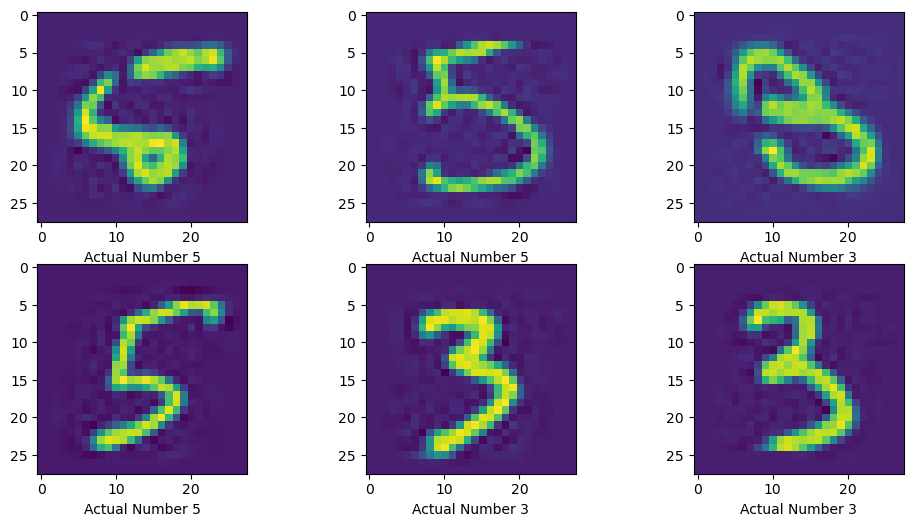

The testing avg error of the dataset is: 12.356290225115313




In [265]:
import matplotlib.pyplot as plt
import pickle
import random


def load_dataset(filename, *keys):
    """ 
    
        Loads dataset mnsit35
    
    """
    if not filename.endswith(".pkl"):
        filename = filename + ".pkl"
    with open(Path("..", "data", filename), "rb") as (f):
        data = pickle.load(f)
        if not keys:
            return data
        return [data[k] for k in keys]

def get_relative_error(
        
        X,
        model, 
        num_points,
        y=None, 
        plot=True, 
        class_labels=['3', '5']
        
    ):
    """ 

        evaluate the model

    """

    fitted_data = np.reshape(X, (X.shape[0], -1))

    reduced_data = model.transform(fitted_data)
    created_data = model.inverse_transform(reduced_data)
    err = []
    
    for i in range(int(num_points) - 1):
       
        error_per_point = np.linalg.norm(created_data[i] - X[i], ord=2) / (
            np.linalg.norm(X[i], ord=2))
        error = error_per_point * 100
        err.append(error)
    
    reconstruction_error = np.array(err)

    if plot:

        # visualize a sample of reconstructed data images
        created_data = np.reshape(created_data, (created_data.shape[0], 28, 28))


        # randomly select 5 images from 1 to num_pics_to_load
        rand_Images_idx = random.sample(range(num_points), 6)

        fig, axs = plt.subplots(2, 3, figsize=(12, 6))
        col = 0
        row = 0

        for i, idx in enumerate(rand_Images_idx):
            
            axs[row, col].imshow(created_data[i].real)
            axs[row, col].set_xlabel("Actual Number {}".format(class_labels[y[i]]))

            if col == 2:

                row += 1
                col = 0

            else:

                col += 1

        plt.show()

    return reconstruction_error

    
f = r"C:\Users\johnk\Documents\projects\ubc\cpsc540\a3\data\mnist35.pkl"

X, y, Xtest, ytest = load_dataset(f, "X", "y", "Xtest", "ytest")

# determine samples
num_samples = X.shape[0]

# y = y[:10000]
Xtest = np.reshape(Xtest, (Xtest.shape[0], -1))
# ytest = ytest[:10000]
model = ppca(X=X, num_components=200)

print("=======>Training Phase<=======")
error_train = get_relative_error(X, model, num_samples, y=y, plot=False)
print("The avg error of the dataset is: {0}\n\n".format(np.mean(error_train)))

print("=======>Testing Phase<=======")
error_test = get_relative_error(Xtest, model, Xtest.shape[0], y=ytest)
print("The testing avg error of the dataset is: {0}\n\n".format(np.mean(error_test)))


0


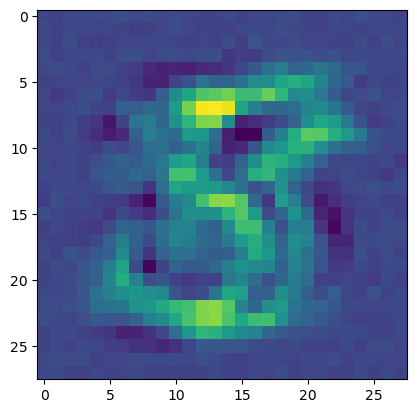

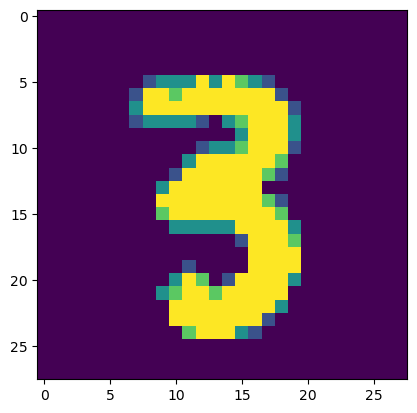

In [201]:
print(err[1][13])
plt.imshow(err[0][13].reshape(28, 28))
plt.show()
plt.imshow(data['Xtest'][13, :].reshape(28, 28))


---

Data mean:
[2662.32666667 3019.5       ]
Data cov:
[[24828.9596868    102.74161074]
 [  102.74161074   218.01006711]]


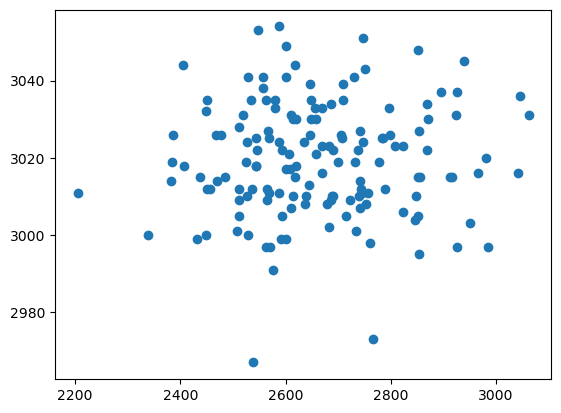

In [136]:
# --------------------------------------------

# Import data

#
import matplotlib.pyplot as plt

data = import_data()

# figs = {}
# figs["data"] = plot_hist_2d(data, "Data")

d = data.shape[1]
plt.plot(data[:, 0], data[:, 1], 'o')
print("\n---\n")

mu_ml = np.mean(data,axis=0)
print("Data mean:")
print(mu_ml)

data_cov = np.cov(data,rowvar=False)
print("Data cov:")
print(data_cov)



---

Var ML:
217.58116636932957
uq:
[[-0.99999129]
 [-0.00417452]]
lambdaq
[[24829.38858755]]
Weight matrix ML:
[[-156.88014062]
 [  -0.65490514]]
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2,)
(1, 1) (1, 2) (2

(array([ 4.,  9., 16., 22., 27., 36., 21., 11.,  3.,  1.]),
 array([-2.52587307, -1.98594123, -1.44600938, -0.90607754, -0.36614569,
         0.17378616,  0.713718  ,  1.25364985,  1.7935817 ,  2.33351354,
         2.87344539]),
 <BarContainer object of 10 artists>)

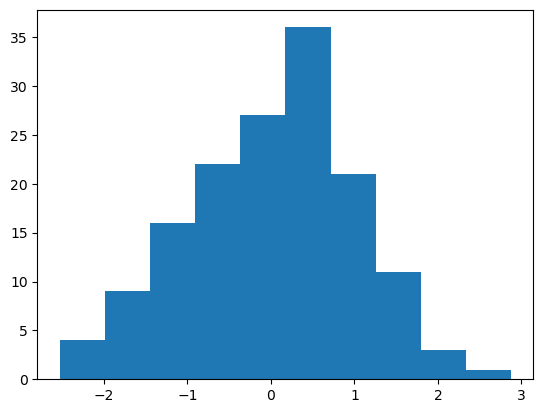

In [105]:
# -------------------------------------------------------------------

# Max. likelihood

#

print("\n---\n")

# No hidden variables < no visibles = d
q = 1

# Variance
lambdas, eigenvecs = np.linalg.eig(data_cov)
idx = lambdas.argsort()[::-1]   
lambdas = lambdas[idx]
eigenvecs = - eigenvecs[:,idx]

var_ml = (1.0 / (d-q)) * sum([lambdas[j] for j in range(q,d)])
print("Var ML:")
print(var_ml)

# Weight matrix
uq = eigenvecs[:,:q]
print("uq:")
print(uq)

lambdaq = np.diag(lambdas[:q])
print("lambdaq")
print(lambdaq)

weight_ml = uq * np.sqrt(lambdaq - var_ml * np.eye(q))
print("Weight matrix ML:")
print(weight_ml)

def sample_hidden_given_visible(
    weight_ml : np.array, 
    mu_ml : np.array,
    var_ml : float,
    visible_samples : np.array
    ) -> np.array:

    q = weight_ml.shape[1]
    m = np.transpose(weight_ml) @ weight_ml + var_ml * np.eye(q)

    cov = var_ml * np.linalg.inv(m)
    act_hidden = []
    for data_visible in visible_samples:
        print(m.shape, np.transpose(weight_ml).shape, (data_visible - mu_ml).shape)

        mean = np.linalg.inv(m) @ np.transpose(weight_ml) @ (data_visible - mu_ml)
        sample = np.random.multivariate_normal(mean,cov,size=1)
        act_hidden.append(sample[0])
    
    return np.array(act_hidden)

act_hidden = sample_hidden_given_visible(
    weight_ml=weight_ml,
    mu_ml=mu_ml,
    var_ml=var_ml,
    visible_samples=data
    )

plt.hist(act_hidden)


---

Data mean:
[2662.32666667 3019.5       ]
Data cov:
[[24828.9596868    102.74161074]
 [  102.74161074   218.01006711]]


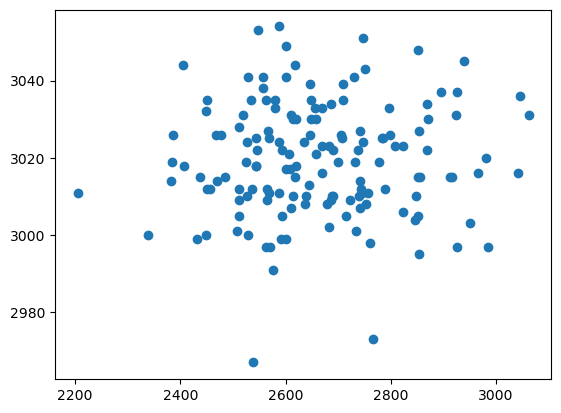

In [137]:
d = data.shape[1]
plt.plot(data[:, 0], data[:, 1], 'o')
print("\n---\n")

mu_ml = np.mean(data,axis=0)
print("Data mean:")
print(mu_ml)

data_cov = np.cov(data,rowvar=False)
print("Data cov:")
print(data_cov)

[2662.32666667 3019.5       ]
(150, 2)


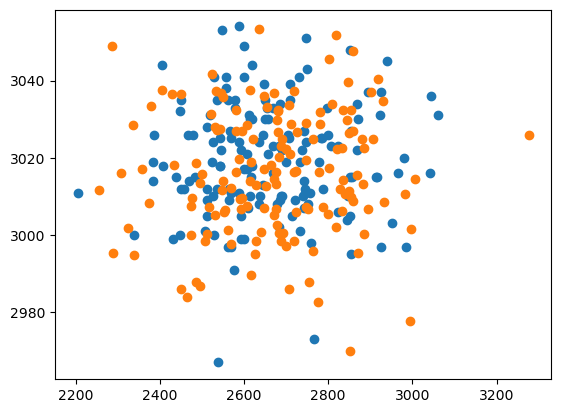

In [138]:
model = ppca(X=data, num_components=1)


# mean_hidden = np.full(q,0)
# cov_hidden = np.eye(q)
print(data.shape)

# no_samples = len(data)
# X_test = np.random.multivariate_normal(mean_hidden,cov_hidden,size=no_samples)
# plt.hist(model.predict(data)[:, 1])
gen = model.predict(data)
plt.plot(data[:, 0], data[:, 1], 'o')
plt.plot(gen[:, 0], gen[:, 1], 'o')